In [ ]:
# Importing Libraries
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt

In [ ]:
# Load preprocessed numpy arrays for data and target
data=np.load('/content/drive/MyDrive/Colab Notebooks/rp/data-preprocessed-disease.npy')
target=np.load('/content/drive/MyDrive/Colab Notebooks/rp/target-preprocessed-disease.npy')

In [ ]:
data.shape

(1083, 224, 224, 3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create the base MobileNetV2 model with pre-trained weights
# include_top=False - load model without output layer
from tensorflow.keras.optimizers import Adam
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224,224, 3)))

# Build the head of the model on top of the base model
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(6, activation="softmax")(headModel)

# Combine the base and head models
model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze the layers in the base model so they are not trainable during training
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer= Adam(learning_rate=0.0005),metrics=["accuracy"])
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

In [ ]:
# Split the data into training and testing sets
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2)

In [ ]:
# Set up a callback to save the model weights during training
checkpoint = ModelCheckpoint('modelso/model-{epoch:03d}.model',monitor='val_loss',save_best_only=True,mode='auto')
# Train the model
history = model.fit(train_data, train_target, validation_data=(test_data, test_target),epochs=100, batch_size=8)

Epoch 1/100
109/109 [==============================] - 17s 40ms/step - loss: 1.2414 - accuracy: 0.5231 - val_loss: 0.7668 - val_accuracy: 0.7097
Epoch 2/100
109/109 [==============================] - 2s 17ms/step - loss: 0.7368 - accuracy: 0.6998 - val_loss: 0.6085 - val_accuracy: 0.7558
Epoch 3/100
109/109 [==============================] - 2s 20ms/step - loss: 0.5352 - accuracy: 0.7887 - val_loss: 0.5046 - val_accuracy: 0.7742
Epoch 4/100
109/109 [==============================] - 2s 18ms/step - loss: 0.4507 - accuracy: 0.8164 - val_loss: 0.4496 - val_accuracy: 0.7880
Epoch 5/100
109/109 [==============================] - 2s 19ms/step - loss: 0.3472 - accuracy: 0.8695 - val_loss: 0.4804 - val_accuracy: 0.8065
Epoch 6/100
109/109 [==============================] - 2s 17ms/step - loss: 0.2980 - accuracy: 0.8938 - val_loss: 0.4675 - val_accuracy: 0.8065
Epoch 7/100
109/109 [==============================] - 2s 17ms/step - loss: 0.2700 - accuracy: 0.8915 - val_loss: 0.4085 - val_accuracy

Text(0, 0.5, 'loss')

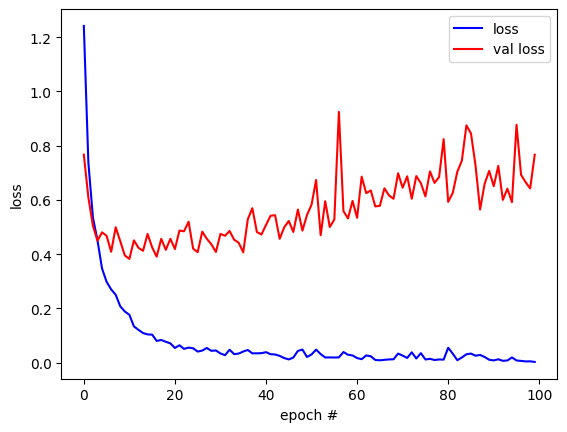

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'],'b',label='loss')
plt.plot(history.history['val_loss'],'r',label='val loss')
plt.legend()
plt.xlabel('epoch #')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

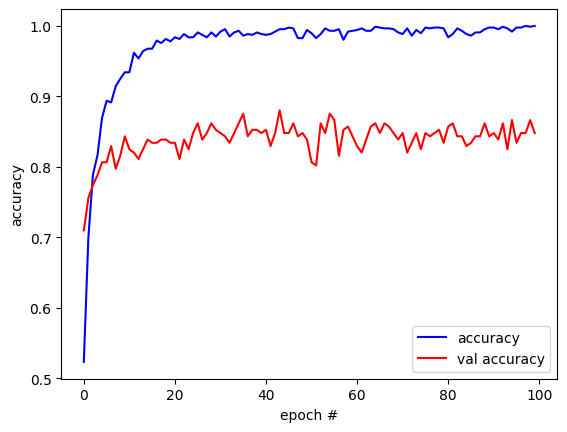

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'],'b',label='accuracy')
plt.plot(history.history['val_accuracy'],'r',label='val accuracy')
plt.legend()
plt.xlabel('epoch #')
plt.ylabel('accuracy')

In [ ]:
# Evaluate the model on the test data
print(model.evaluate(test_data,test_target))

7/7 [==============================] - 2s 129ms/step - loss: 0.7666 - accuracy: 0.8479
[0.7665562033653259, 0.8479262590408325]


In [ ]:
# Save the trained model
model.save('MobileNetV2.model')

In [ ]:
predicted_target=model.predict(test_data)

7/7 [==============================] - 1s 46ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(test_target,axis=1),np.argmax(predicted_target,axis=1),target_names=['Black Mould', 'Cobweb', 'Mite', 'Green Mold', 'Bacterial blotch','Healthy']))

                  precision    recall  f1-score   support

     Black Mould       0.86      0.74      0.79        42
          Cobweb       0.79      0.79      0.79        19
            Mite       0.97      0.86      0.91        42
      Green Mold       0.69      0.89      0.78        45
Bacterial blotch       0.91      0.59      0.71        17
         Healthy       0.93      1.00      0.96        52

        accuracy                           0.85       217
       macro avg       0.86      0.81      0.82       217
    weighted avg       0.86      0.85      0.85       217



In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

matrix=confusion_matrix(np.argmax(test_target,axis=1),np.argmax(predicted_target,axis=1))
print(matrix)

[[31  0  1 10  0  0]
 [ 0 15  0  2  1  1]
 [ 1  0 36  5  0  0]
 [ 4  1  0 40  0  0]
 [ 0  3  0  1 10  3]
 [ 0  0  0  0  0 52]]


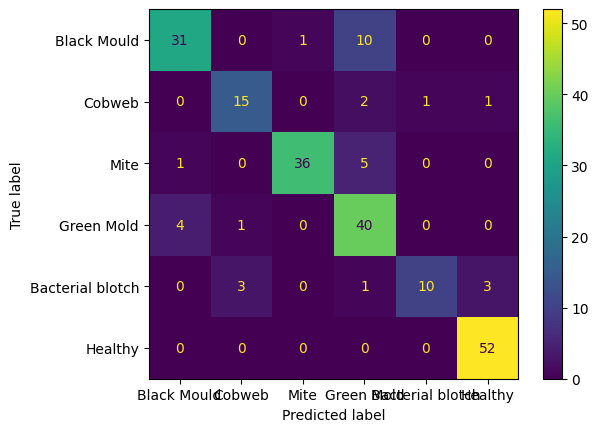

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Black Mould', 'Cobweb', 'Mite', 'Green Mold', 'Bacterial blotch', 'Healthy'])
disp.plot()